In [1]:
import os
import scipy
import numpy as np
import pandas as pd

import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,7)
plt.ion()  # To trigger the interactive inline mode
%matplotlib inline

In [2]:
site_lat = -14.668889 
site_lon = 145.459444

In [3]:
selectedDepthIndex = 16

In [4]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

In [5]:
# Define starting and ending date of the netcdf file we want to load 
start_date = dt.date(2011, 1, 1)
end_date = dt.date(2016, 12, 1)
delta = relativedelta(months=+1)

# Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
step = True
while start_date <= end_date:
    
    # Read individual file from the OpeNDAP server
    netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
    print('Processing time interval:',netCDF_datestr)
    inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"
    start_date += delta    
    nc_data = Dataset(inputFile, 'r')
    ncdata = nc_data.variables
    
    # Get parameters values for each single file
    if step:
        lat = ncdata['latitude'][:].filled(fill_value=0.)
        lon = ncdata['longitude'][:].filled(fill_value=0.)
        times = ncdata['time'][:]
        selectedLatIndex = find_nearest(lat,site_lat)
        selectedLonIndex = find_nearest(lon,site_lon)
        temperature = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        salinity = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
    else:
        days = ncdata['time'][:]
        times = np.hstack((times,days))
        dailyTemp = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        temperature = np.hstack((temperature,dailyTemp))
        dailySalt = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        salinity = np.hstack((salinity,dailySalt))
    step = False


time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

# Create a pandas dataframe containing the information from all the files
df = pd.DataFrame(
    data={
        "date": time,
        "salinity": salinity,
        "temperature": temperature,
    }
)

# Store these informations on a file in case you want to reuse them later on without having to 
# rerun this cell...
df.to_csv(
        "LizardIsland_timeseries.csv",
        columns=["date", "salinity", "temperature"],
        sep=" ",
        index=False,
        header=1,
    )

Processing time interval: 2011-01
Processing time interval: 2011-02
Processing time interval: 2011-03
Processing time interval: 2011-04
Processing time interval: 2011-05
Processing time interval: 2011-06
Processing time interval: 2011-07
Processing time interval: 2011-08
Processing time interval: 2011-09
Processing time interval: 2011-10
Processing time interval: 2011-11
Processing time interval: 2011-12
Processing time interval: 2012-01
Processing time interval: 2012-02
Processing time interval: 2012-03
Processing time interval: 2012-04
Processing time interval: 2012-05
Processing time interval: 2012-06
Processing time interval: 2012-07
Processing time interval: 2012-08
Processing time interval: 2012-09
Processing time interval: 2012-10
Processing time interval: 2012-11
Processing time interval: 2012-12
Processing time interval: 2013-01
Processing time interval: 2013-02
Processing time interval: 2013-03
Processing time interval: 2013-04
Processing time interval: 2013-05
Processing tim

In [6]:
df = pd.read_csv(
        "LizardIsland_timeseries.csv",
        sep=r"\s+",
        engine="c",
        header=0,
        na_filter=False,
        low_memory=False,
    )
df['date']= pd.to_datetime(df['date'])

In [7]:
df

,date,salinity,temperature
0,2011-01-01,34.902670,29.219854
1,2011-01-02,34.857180,29.366589
2,2011-01-03,34.916954,29.524550
3,2011-01-04,34.913326,30.090927
4,2011-01-05,34.930504,30.627514
...,...,...,...
2187,2016-12-27,35.541450,28.861048
2188,2016-12-28,35.522415,28.883990
2189,2016-12-29,35.442630,28.641617
2190,2016-12-30,35.443188,29.265848


In [8]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

salinity_roll = rolling["salinity"]
temperature_roll = rolling["temperature"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "salinity": df['salinity'],
                "salinity_roll": salinity_roll,
                "temperature": df['temperature'],
                "temperature_roll": temperature_roll,
            }
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,salinity,salinity_roll,temperature,temperature_roll,day,month,year
0,2011-01-01,34.902670,34.902670,29.219854,29.219854,1,1,2011
1,2011-01-02,34.857180,34.879925,29.366589,29.293222,2,1,2011
2,2011-01-03,34.916954,34.892268,29.524550,29.370331,3,1,2011
3,2011-01-04,34.913326,34.897532,30.090927,29.550480,4,1,2011
4,2011-01-05,34.930504,34.904127,30.627514,29.765887,5,1,2011
...,...,...,...,...,...,...,...,...
2187,2016-12-27,35.541450,35.340345,28.861048,28.302647,27,12,2016
2188,2016-12-28,35.522415,35.348426,28.883990,28.345311,28,12,2016
2189,2016-12-29,35.442630,35.353450,28.641617,28.376951,29,12,2016
2190,2016-12-30,35.443188,35.357843,29.265848,28.408875,30,12,2016


In [10]:
def getSeason(param):
    tdf = (timeseries.groupby(["year", "month"])[[param]]
                    .apply(np.mean)
                    .reset_index()
        )

    dfseason = tdf.pivot(index="year", columns="month", values=param)

    dfseason = dfseason.rename(
        columns={
            1: "January",
            2: "February",
            3: "March",
            4: "April",
            5: "May",
            6: "June",
            7: "July",
            8: "August",
            9: "September",
            10: "October",
            11: "November",
            12: "December",
        }
    )

    return dfseason

# Let's call the function
Temp_season = getSeason('temperature')
Salt_season = getSeason('salinity')

/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


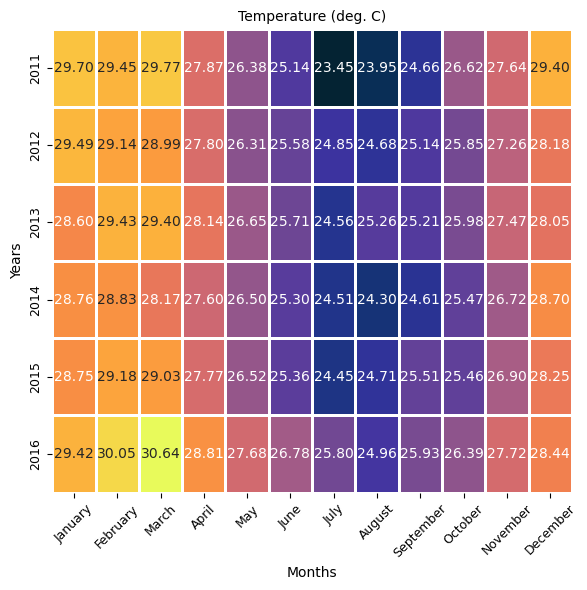

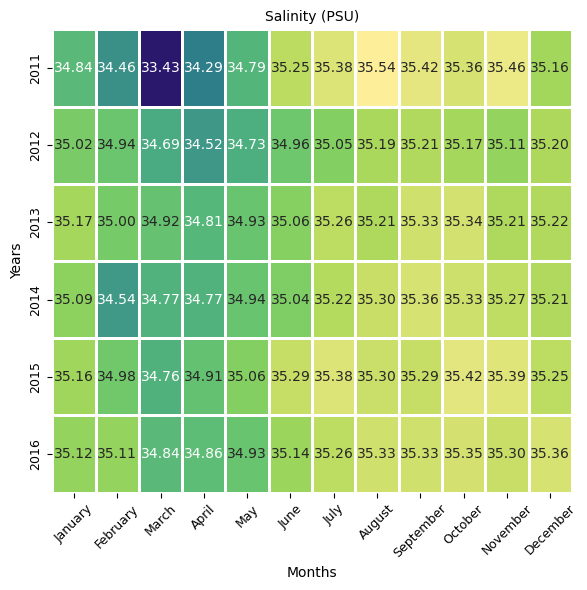

In [11]:
# Temperature
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    Temp_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=False
)
ax.set_title("Temperature (deg. C)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Salinity
color = cmocean.cm.haline
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    Salt_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=False
)
ax.set_title("Salinity (PSU)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Define starting and ending date of the netcdf file we want to load 
start_date = dt.date(2011, 1, 1)
end_date = dt.date(2016, 12, 1)
delta = relativedelta(months=+1)

# Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
step = True
while start_date <= end_date:
    
    # Read individual file from the OpeNDAP server
    netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
    print('Processing time interval:',netCDF_datestr)
    inputFile = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"+netCDF_datestr+".nc"
    start_date += delta    
    nc_data = Dataset(inputFile, 'r')
    ncdata = nc_data.variables
    
    # Get parameters values for each single file
    if step:
        lat = ncdata['latitude'][:].filled(fill_value=0.)
        lon = ncdata['longitude'][:].filled(fill_value=0.)
        times = ncdata['time'][:]
        selectedLatIndex = find_nearest(lat,site_lat)
        selectedLonIndex = find_nearest(lon,site_lon)
        PH = nc_data.variables['PH'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
    else:
        days = ncdata['time'][:]
        times = np.hstack((times,days))
        dailyPH = nc_data.variables['PH'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
        PH = np.hstack((PH,dailyPH))
    step = False


time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

# Create a pandas dataframe containing the information from all the files
df = pd.DataFrame(
    data={
        "date": time,
        "PH": PH,
    }
)

# Store these informations on a file in case you want to reuse them later on without having to 
# rerun this cell...
df.to_csv(
        "LizardIsland_timeseries2.csv",
        columns=["date", "PH"],
        sep=" ",
        index=False,
        header=1,
    )

Processing time interval: 2011-01
Processing time interval: 2011-02
Processing time interval: 2011-03
Processing time interval: 2011-04
Processing time interval: 2011-05
Processing time interval: 2011-06
Processing time interval: 2011-07
Processing time interval: 2011-08
Processing time interval: 2011-09
Processing time interval: 2011-10
Processing time interval: 2011-11
Processing time interval: 2011-12
Processing time interval: 2012-01
Processing time interval: 2012-02
Processing time interval: 2012-03
Processing time interval: 2012-04
Processing time interval: 2012-05
Processing time interval: 2012-06
Processing time interval: 2012-07
Processing time interval: 2012-08
Processing time interval: 2012-09
Processing time interval: 2012-10
Processing time interval: 2012-11
Processing time interval: 2012-12
Processing time interval: 2013-01
Processing time interval: 2013-02
Processing time interval: 2013-03
Processing time interval: 2013-04
Processing time interval: 2013-05
Processing tim

In [13]:
df2 = pd.read_csv(
        "LizardIsland_timeseries2.csv",
        sep=r"\s+",
        engine="c",
        header=0,
        na_filter=False,
        low_memory=False,
    )
df2['date']= pd.to_datetime(df2['date'])

In [14]:
df2

,date,PH
0,2011-01-01 12:00:00,8.027571
1,2011-01-02 12:00:00,8.024555
2,2011-01-03 12:00:00,8.026835
3,2011-01-04 12:00:00,8.024101
4,2011-01-05 12:00:00,8.021058
...,...,...
2187,2016-12-27 12:00:00,8.016210
2188,2016-12-28 12:00:00,8.019666
2189,2016-12-29 12:00:00,8.030743
2190,2016-12-30 12:00:00,8.031332


In [15]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df2.rolling(str(days) + "D", on="date", min_periods=1).mean()

PH_roll = rolling["PH"]

# Let us store these means in a new datafame
timeseries2 = pd.DataFrame(
            data={
                "date": df2['date'],
                "PH": df2['PH'],
                "PH_roll": PH_roll,
            }
        )

timeseries2["day"] = timeseries2["date"].dt.day
timeseries2["month"] = timeseries2["date"].dt.month
timeseries2["year"] = timeseries2["date"].dt.year

# Let's open the new dataframe
timeseries2

,date,PH,PH_roll,day,month,year
0,2011-01-01 12:00:00,8.027571,8.027571,1,1,2011
1,2011-01-02 12:00:00,8.024555,8.026063,2,1,2011
2,2011-01-03 12:00:00,8.026835,8.026320,3,1,2011
3,2011-01-04 12:00:00,8.024101,8.025766,4,1,2011
4,2011-01-05 12:00:00,8.021058,8.024824,5,1,2011
...,...,...,...,...,...,...
2187,2016-12-27 12:00:00,8.016210,8.042036,27,12,2016
2188,2016-12-28 12:00:00,8.019666,8.041047,28,12,2016
2189,2016-12-29 12:00:00,8.030743,8.040469,29,12,2016
2190,2016-12-30 12:00:00,8.031332,8.040128,30,12,2016


In [17]:
def getSeason(param):
    tdf = (timeseries2.groupby(["year", "month"])[[param]]
                    .apply(np.mean)
                    .reset_index()
        )

    dfseason = tdf.pivot(index="year", columns="month", values=param)

    dfseason = dfseason.rename(
        columns={
            1: "January",
            2: "February",
            3: "March",
            4: "April",
            5: "May",
            6: "June",
            7: "July",
            8: "August",
            9: "September",
            10: "October",
            11: "November",
            12: "December",
        }
    )

    return dfseason

# Let's call the function
PH_season = getSeason('PH')

/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


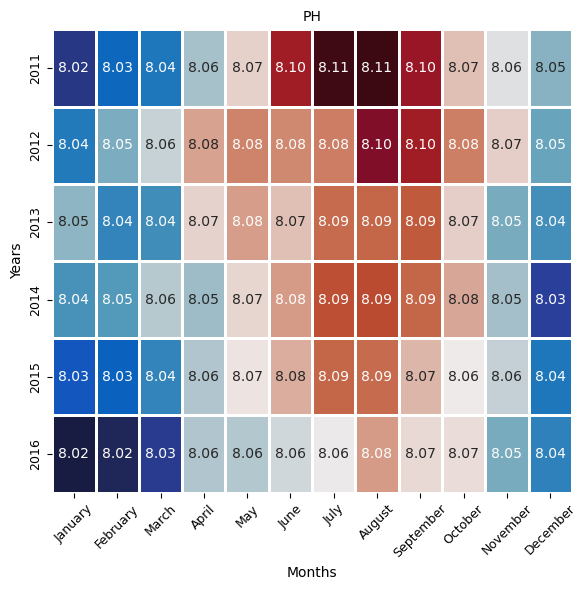

In [18]:
# PH
color = cmocean.cm.balance
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    PH_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=False
)
ax.set_title("PH", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

